<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

In [1]:
 !pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import warnings
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
from copy import deepcopy

warnings.filterwarnings("ignore")

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах (на примере одного устройства). Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса. 

Мы будем использовать дневные данные реального банкомата хоть и не с российского рынка, но очень схожего с ним - турецкого. Скачаем и загрузим их:

In [3]:
url = 'https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv'
output = 'atm_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df = pd.read_csv('atm_daily_cash.csv')
df = df[4:] #лучше избавиться от нескольких пропущенных значений в начале сразу,
            #могут доставлять ненужные лишние проблемы

Downloading...
From: https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv
To: /content/atm_daily_cash.csv
26.1kB [00:00, 18.1MB/s]                   


Взглянем на то, что представляют из себя данные:

In [4]:
df.head()

Date   CashIn  CashOut
4  1/5/2016  20840.0  22200.0
5  1/6/2016  28460.0  18810.0
6  1/7/2016  19250.0  23210.0
7  1/8/2016  49770.0   4350.0
8  1/9/2016      NaN      NaN

В нашем распоряжении пополнения и изъятия; нас интересует нетто. Для этого будем учитывать изъятия со знаком минус, а нетто определим как сумму (такое представление пригодится нам в дальнейшем).

In [5]:
df['CashOut'] = -df['CashOut']
df['target'] = df['CashIn'] + df['CashOut']

### Задание 1. EDA (1 балл)

Проведите разведывательный анализ данных - постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

In [6]:
df.isna().sum(axis=0)

Date         0
CashIn     101
CashOut     88
target     110
dtype: int64

In [7]:
df.describe()

CashIn        CashOut        target
count    1081.000000    1094.000000   1072.000000
mean    37261.618871  -30985.648995   5976.651119
std     20583.186636   18314.048275  21551.659802
min       100.000000 -111700.000000 -75190.000000
25%     21690.000000  -40375.000000  -6277.500000
50%     34980.000000  -27895.000000   5320.000000
75%     50280.000000  -18010.000000  18515.000000
max    121300.000000      -0.000000  85160.000000

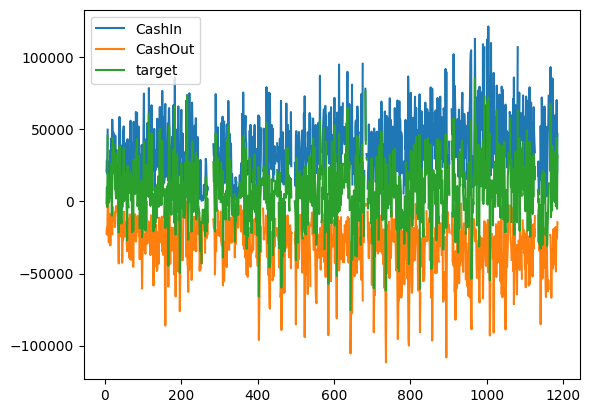

In [8]:
df.plot();

*Возьму несколько недельных срезов для анализа данных, первый понедельник - строка с индексом 10 (1/11/2016). Дальше буду брать открезки по 7 дней, на которых нет пустых ячеек*

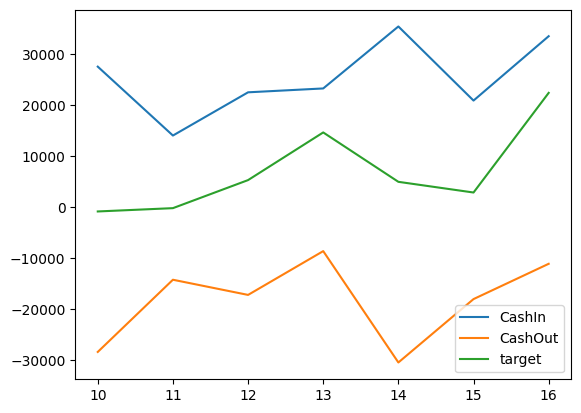

In [9]:
df[6:13].plot();

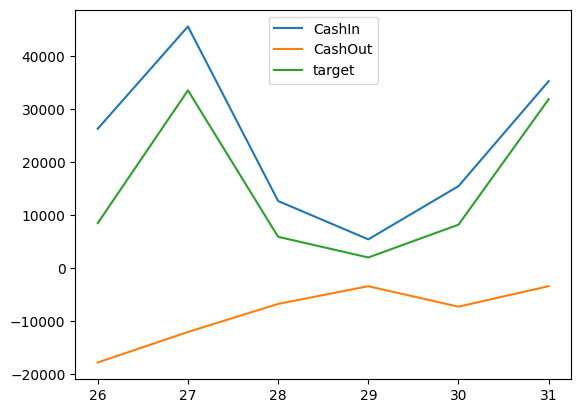

In [10]:
df[22:29].plot();

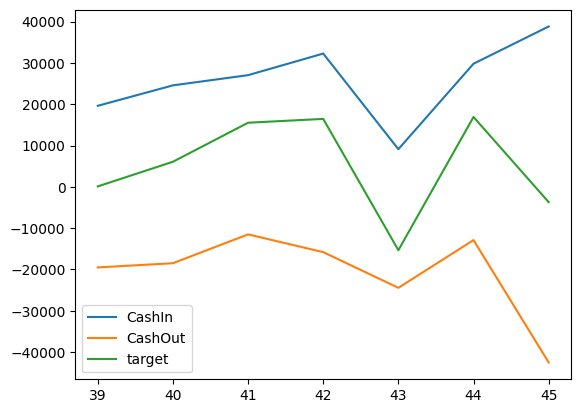

In [11]:
df[35:42].plot();

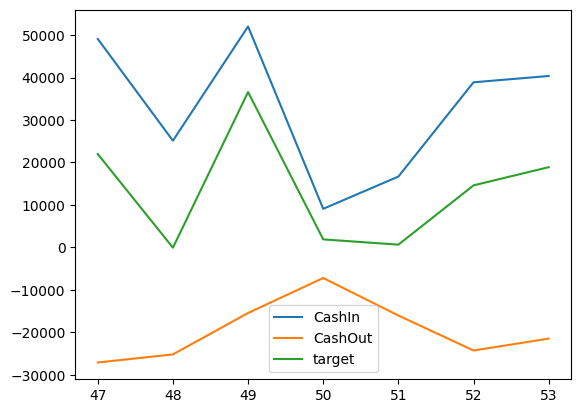

In [12]:
df[43:50].plot();

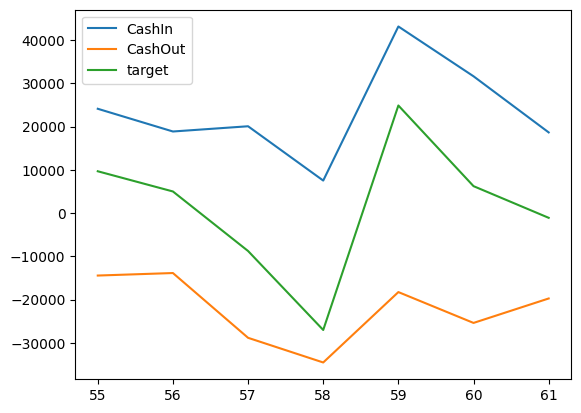

In [13]:
df[51:58].plot();

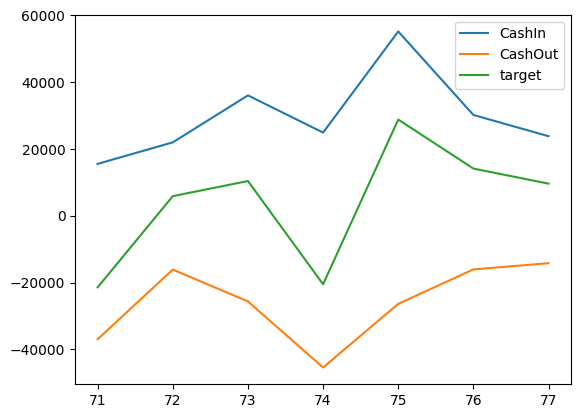

In [14]:
df[67:74].plot();

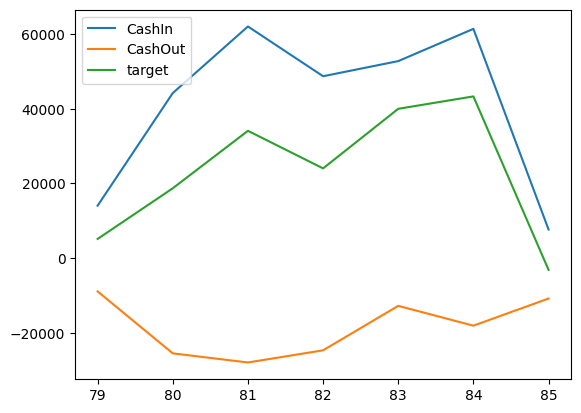

In [15]:
df[75:82].plot();

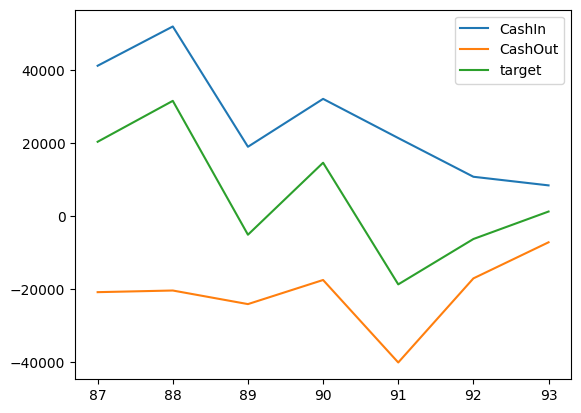

In [16]:
df[83:90].plot();

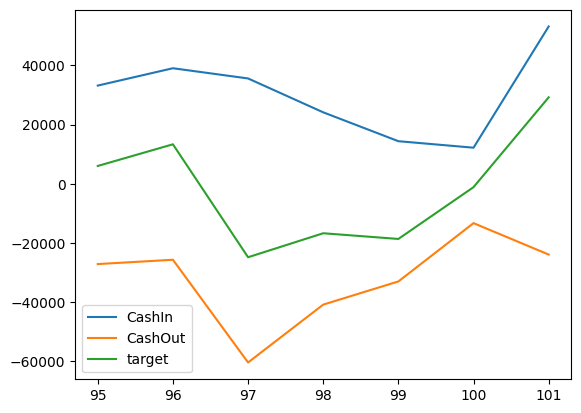

In [17]:
df[91:98].plot();

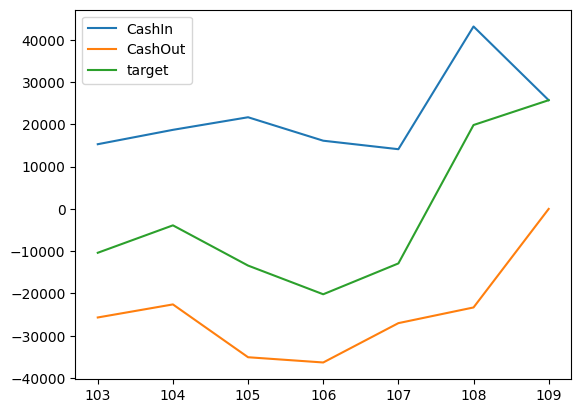

In [18]:
df[99:106].plot();

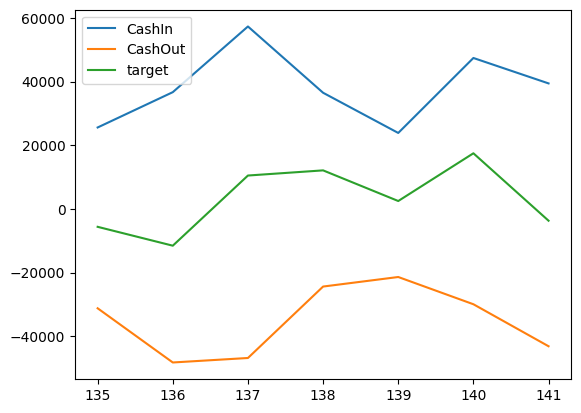

In [19]:
df[131:138].plot();

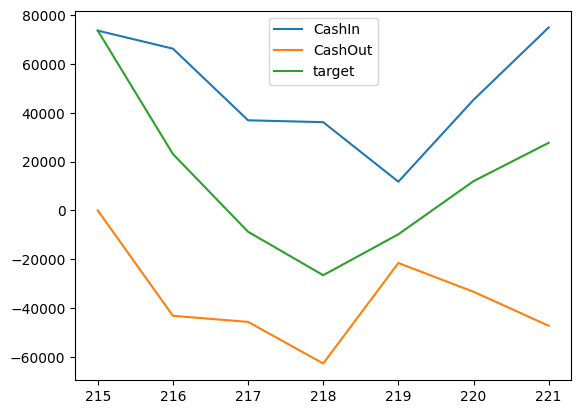

In [20]:
df[211:218].plot();

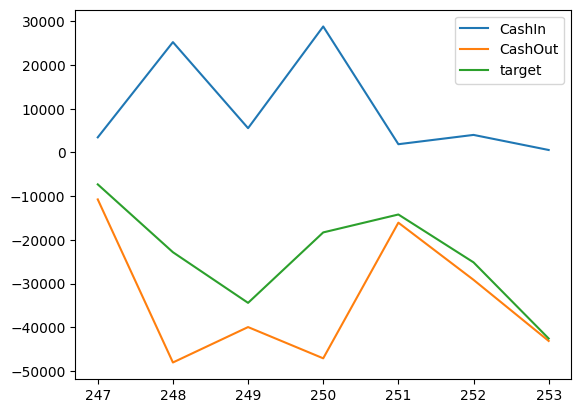

In [21]:
df[243:250].plot();

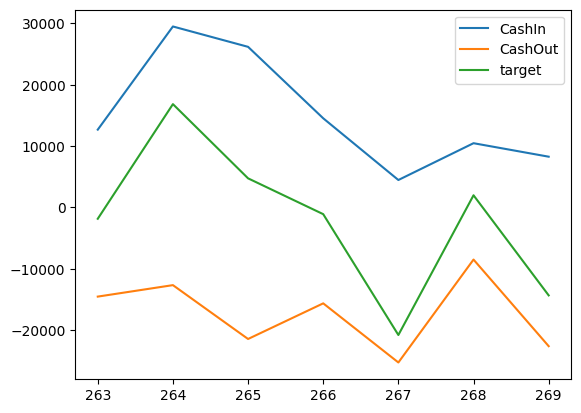

In [22]:
df[259:266].plot();

*Глядя на графики, можно заметить, что наблюдается сезонность по неделям. Что касается тренда, я не очень разбираюсь в экономике, но, по-моему, он прямой, то есть показатели в начале недели очень блики к показателям в конце недели. Также послеживаются некие закономерности. CashOut убывает к середине недели, но возрастает к концу недели. Что касается CashIn, он обычно проседает в середине недели 1-2 раза. Target очень варьируется, что логично, но обычно он больше похож по траектории на CashIn. Возможно, показатели падают в середине недели, потому что люди заняты работой и склонны откладывать дела на начало или конец недели.*

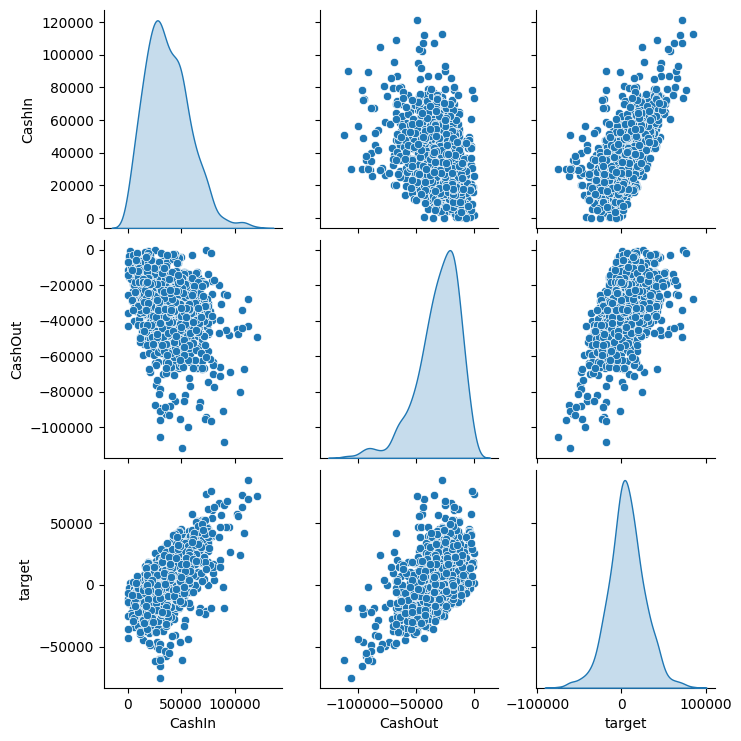

In [23]:
sns.pairplot(df, diag_kind="kde");

*На данном графике прослеживается линейная зависимость между CashIn и target, CashOut и target. Это логично, учитывая, что target=CashIn+CashOut. Зависимость между CashIn и CashOut больше похожа на случайную.*

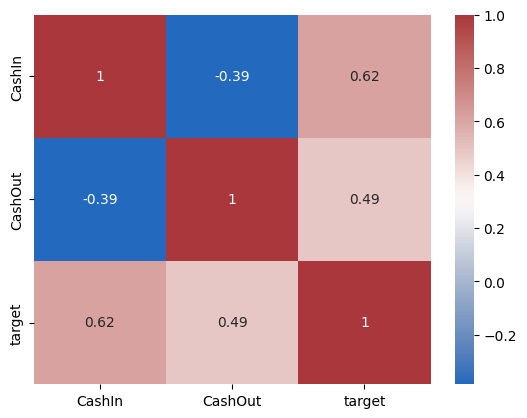

In [24]:
cmap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(df.corr("pearson"), annot=True, cmap=cmap);

*Можно заметить, что target больше коррелирует с CashIn, чем с CashOut. Это также было заметно на графиках. Возможно, это связано с тем, что среднее CashIn чуть больше по модулю, чем среднее CashOut. Это можно увидеть выше на табличке со статистикой по датасету.*

### Задание 2. Приведение в формат multi-segment (0.75 балла)

Теперь нам предстоит (в первый раз) привести данные к формату, в котором с ними будет возможно работать средствами ETNA. Вначале мы будем рассматривать и предсказывать наши данные как мульти-сегментные. Чтобы привести данные в соответствующий формат, вам пригодится функция `pd.melt`. На выходе у нас должен получиться объект `TSDataset`. Поскольку мы будем смотреть на данные не только в этом разрезе, лучше не менять исходный датафрейм и работать с копией.

In [25]:
from etna.datasets import TSDataset

In [26]:
df.head()

Date   CashIn  CashOut   target
4  1/5/2016  20840.0 -22200.0  -1360.0
5  1/6/2016  28460.0 -18810.0   9650.0
6  1/7/2016  19250.0 -23210.0  -3960.0
7  1/8/2016  49770.0  -4350.0  45420.0
8  1/9/2016      NaN      NaN      NaN

In [27]:
#YOUR CODE HERE#
copy = df
ts = pd.melt(copy, id_vars=['Date'], value_vars=['CashIn', 'CashOut', 'target'])
ts

Date variable    value
0      1/5/2016   CashIn  20840.0
1      1/6/2016   CashIn  28460.0
2      1/7/2016   CashIn  19250.0
3      1/8/2016   CashIn  49770.0
4      1/9/2016   CashIn      NaN
...         ...      ...      ...
3541  3/27/2019   target  -3440.0
3542  3/28/2019   target  16640.0
3543  3/29/2019   target  44310.0
3544  3/30/2019   target  -5100.0
3545  3/31/2019   target  32470.0

[3546 rows x 3 columns]

In [28]:
ts["timestamp"] = pd.to_datetime(ts["Date"])
ts["segment"] = ts["variable"]
ts["target"] = ts["value"]
ts.drop(columns=["Date", "variable", "value"], inplace=True)
ts = TSDataset.to_dataset(ts)
ts = TSDataset(ts, freq="D")
ts

segment      CashIn  CashOut   target
feature      target   target   target
timestamp                            
2016-01-05  20840.0 -22200.0  -1360.0
2016-01-06  28460.0 -18810.0   9650.0
2016-01-07  19250.0 -23210.0  -3960.0
2016-01-08  49770.0  -4350.0  45420.0
2016-01-09      NaN      NaN      NaN
...             ...      ...      ...
2019-03-27  45160.0 -48600.0  -3440.0
2019-03-28  39480.0 -22840.0  16640.0
2019-03-29  70260.0 -25950.0  44310.0
2019-03-30  19250.0 -24350.0  -5100.0
2019-03-31  46870.0 -14400.0  32470.0

[1182 rows x 3 columns]

### Задание 3. Работа с пропущенными значениями и аутлаерами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

In [29]:
from etna.analysis import (plot_anomalies_interactive, plot_backtest, plot_forecast, sample_acf_plot)
from etna.analysis.outliers import (get_anomalies_median)
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.metrics import MAE, SMAPE
from etna.models import (CatBoostModelPerSegment, CatBoostMultiSegmentModel, ProphetModel)
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.transforms import (MedianOutliersTransform, TimeSeriesImputerTransform)

*Ранее при анализе данных в 1 задании были выявлены пропущенные значения в данных, думаю, лучше заполнить их средними значениями, так как если нет информации о денежном потоке в определенный день, то безопаснее всего просто предположить, что он был средним и ничем не выделился*

Проверьте ряды на наличие аутлаеров, и очистите их соответствующим образом. Обоснуйте выбор.

*Что касается аутлаеров, я бы сделала здесь все так же, как с пропущенными значениями*

In [30]:
segment = "target"
method = get_anomalies_median
params_bounds = {"window_size": (40, 70, 1), "alpha": (0.1, 4, 0.25)}

In [31]:
plot_anomalies_interactive(
    ts=ts, segment=segment, method=method, params_bounds=params_bounds
)

interactive(children=(IntSlider(value=40, continuous_update=False, description='window_size', max=70, min=40, …

In [32]:
best_params = {"window_size": 55, "alpha": 1.60}

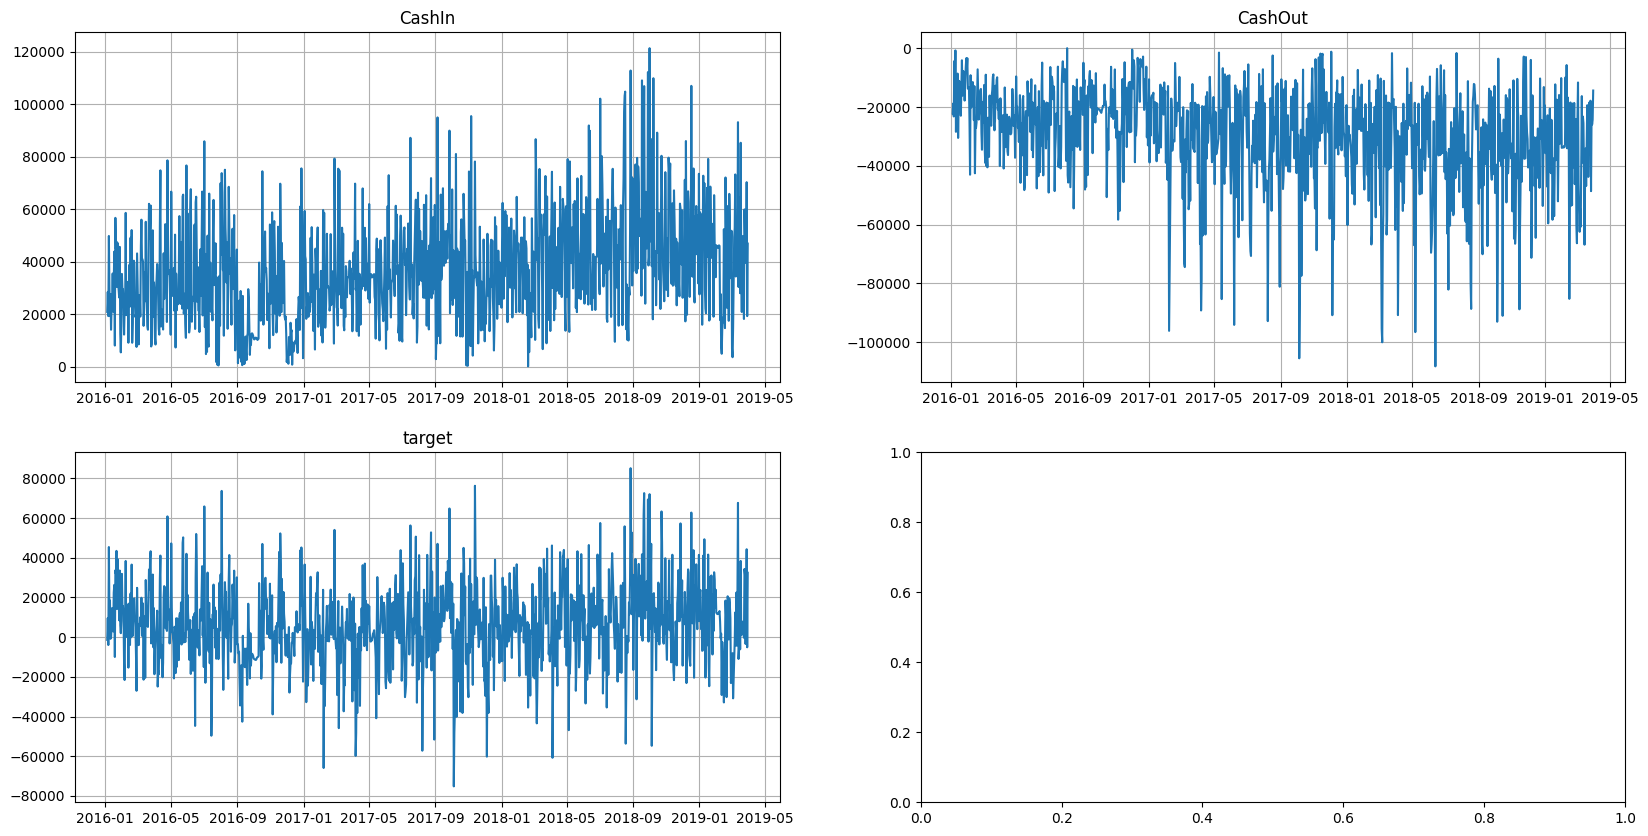

In [33]:
#YOUR CODE HERE#
outliers_remover = MedianOutliersTransform(in_column="target", **best_params)
outliers_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="running_mean", window=30
)
ts.fit_transform([outliers_remover, outliers_imputer])
ts.plot()

In [34]:
ts

segment      CashIn  CashOut   target
feature      target   target   target
timestamp                            
2016-01-05  20840.0 -22200.0  -1360.0
2016-01-06  28460.0 -18810.0   9650.0
2016-01-07  19250.0 -23210.0  -3960.0
2016-01-08  49770.0  -4350.0  45420.0
2016-01-09  29580.0 -17142.5  12437.5
...             ...      ...      ...
2019-03-27  45160.0 -48600.0  -3440.0
2019-03-28  39480.0 -22840.0  16640.0
2019-03-29  70260.0 -25950.0  44310.0
2019-03-30  19250.0 -24350.0  -5100.0
2019-03-31  46870.0 -14400.0  32470.0

[1182 rows x 3 columns]

### Задание 4. Построение мультисегментной модели (1.25 балла)

Постройте мульти-сегментную модель на основе Prophet, и оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [35]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest

In [36]:
HORIZON = 5

In [37]:
#YOUR CODE HERE#
model = ProphetModel()
transforms = []
pipeline = Pipeline(
    model=model,
    transforms=transforms,
    horizon=HORIZON,
)

In [38]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts, metrics=[SMAPE()]
)
metrics_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmhocrm71/ws6aeot6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmhocrm71/culm6ach.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58174', 'data', 'file=/tmp/tmpmhocrm71/ws6aeot6.json', 'init=/tmp/tmpmhocrm71/culm6ach.json', 'output', 'file=/tmp/tmpdjnxydfs/prophet_model-20230514121944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:19:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:19:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True t

segment       SMAPE  fold_number
0   CashIn   26.284586            0
0   CashIn   33.889150            1
0   CashIn   46.061928            2
0   CashIn   18.716276            3
0   CashIn   38.071281            4
1  CashOut   29.494121            0
1  CashOut   31.823277            1
1  CashOut   28.626053            2
1  CashOut   42.052734            3
1  CashOut   50.649646            4
2   target  151.843625            0
2   target  145.612873            1
2   target  131.395627            2
2   target  105.728498            3
2   target  130.526779            4

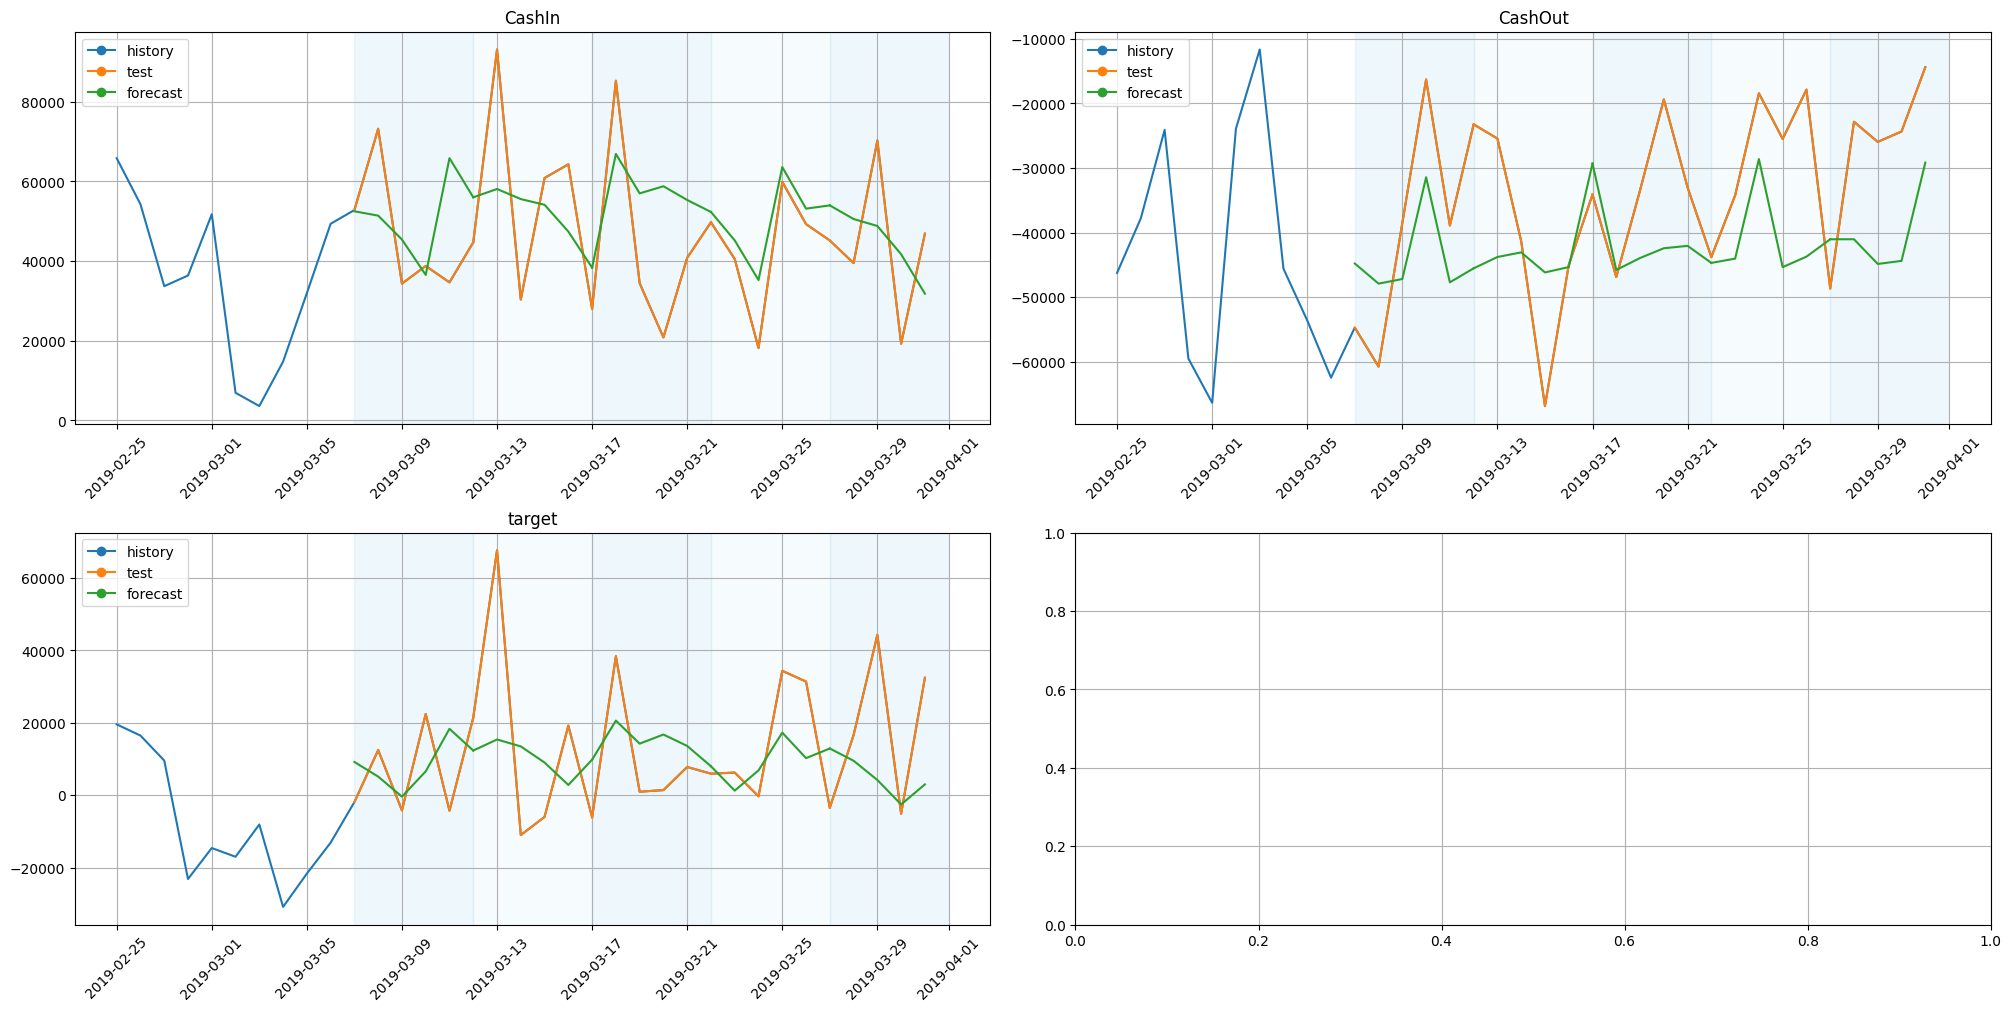

In [39]:
plot_backtest(forecast_df, ts, history_len=10)

Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

*Мне кажется, модель показала себя неплохо, учитывая зашумленность данных, так что такой способ предсказывания считаю вполне подходящим*

In [40]:
#YOUR CODE HERE#
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts, metrics=[MAE()]
)
metrics_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmhocrm71/egwwkcsi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmhocrm71/lntffuw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72122', 'data', 'file=/tmp/tmpmhocrm71/egwwkcsi.json', 'init=/tmp/tmpmhocrm71/lntffuw6.json', 'output', 'file=/tmp/tmpj5cfn836/prophet_model-20230514122029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:20:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:20:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True t

segment           MAE  fold_number
0   CashIn  13326.296527            0
0   CashIn  19031.481791            1
0   CashIn  20752.182500            2
0   CashIn   6388.395474            3
0   CashIn  15769.138865            4
1  CashOut  11063.776892            0
1  CashOut  12660.193325            1
1  CashOut   9682.332397            2
1  CashOut  13308.685929            3
1  CashOut  15884.227584            4
2   target  12135.179968            0
2   target  23452.185303            1
2   target  13634.176116            2
2   target  10482.271297            3
2   target  19112.957650            4

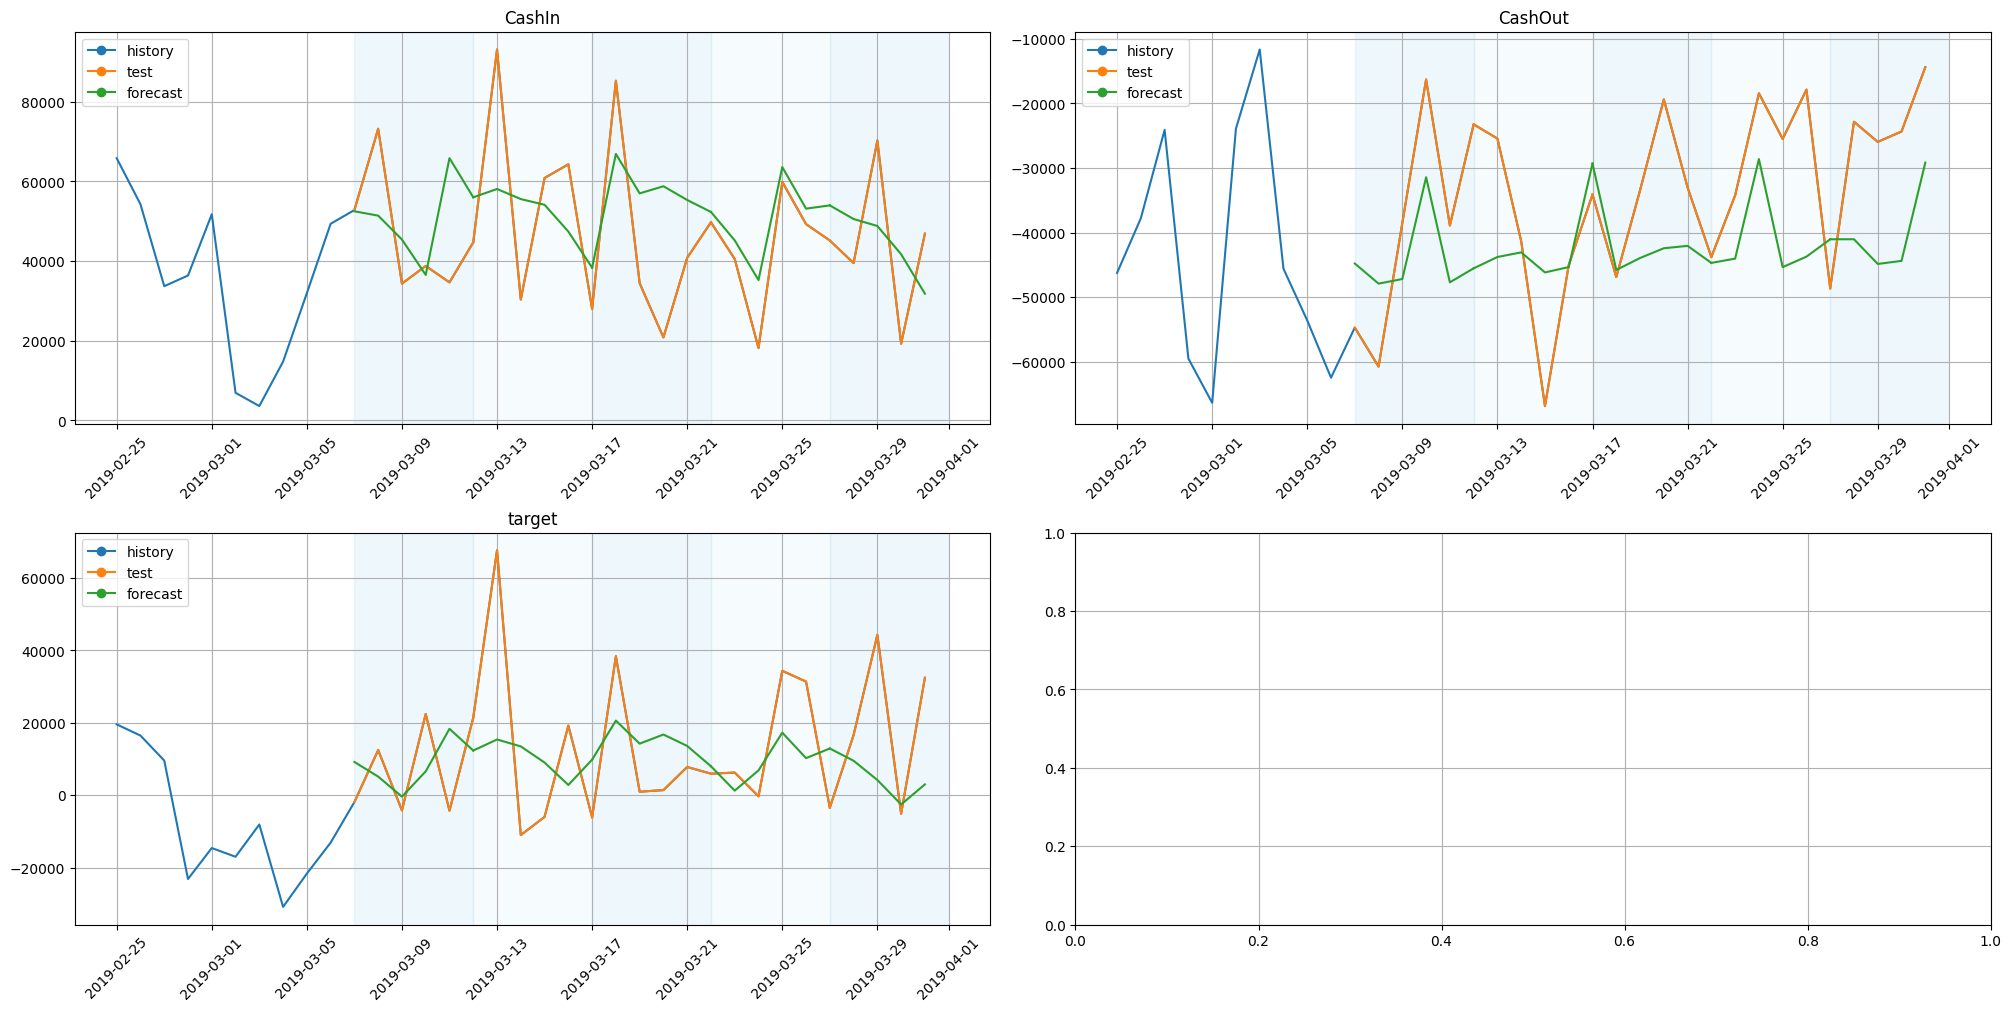

In [41]:
plot_backtest(forecast_df, ts, history_len=10)

### Задание 5. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/tinkoff-ai/etna/blob/master/examples/hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [42]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import BottomUpReconciliator

In [43]:
hierarchical_ts = pd.melt(copy, id_vars=['Date'], value_vars=['CashIn', 'CashOut', 'target'])
hierarchical_ts["timestamp"] = pd.to_datetime(hierarchical_ts["Date"])
hierarchical_ts["segment"] = hierarchical_ts["variable"]
hierarchical_ts["target"] = hierarchical_ts["value"]
hierarchical_ts.drop(columns=["Date", "variable", "value"], inplace=True)
hierarchical_ts = TSDataset.to_dataset(hierarchical_ts)
hierarchical_ts.head()

segment      CashIn  CashOut   target
feature      target   target   target
timestamp                            
2016-01-05  20840.0 -22200.0  -1360.0
2016-01-06  28460.0 -18810.0   9650.0
2016-01-07  19250.0 -23210.0  -3960.0
2016-01-08  49770.0  -4350.0  45420.0
2016-01-09      NaN      NaN      NaN

In [44]:
#YOUR CODE HERE#
hierarchical_structure = HierarchicalStructure(
    level_structure={"total": ["upper", "lower"], "upper": ["target"], "lower": ["CashIn", "CashOut"]}, level_names=["total", "upper", "lower"]
)
hierarchical_ts = TSDataset(df=hierarchical_ts, freq="D", hierarchical_structure=hierarchical_structure)

hierarchical_ts.head()

segment      CashIn  CashOut   target
feature      target   target   target
timestamp                            
2016-01-05  20840.0 -22200.0  -1360.0
2016-01-06  28460.0 -18810.0   9650.0
2016-01-07  19250.0 -23210.0  -3960.0
2016-01-08  49770.0  -4350.0  45420.0
2016-01-09      NaN      NaN      NaN

In [45]:
hierarchical_ts.current_df_level

'lower'

In [46]:
reconciliator = BottomUpReconciliator(target_level="upper", source_level="lower")
reconciliator.fit(ts=hierarchical_ts)
reconciliator.mapping_matrix.toarray()

array([[1, 0, 0],
       [0, 1, 1]], dtype=int32)

In [47]:
reconciliator.aggregate(ts=hierarchical_ts).head(5)

segment      target   CashIn  CashOut
feature      target   target   target
timestamp                            
2016-01-05  -1360.0  20840.0 -22200.0
2016-01-06   9650.0  28460.0 -18810.0
2016-01-07  -3960.0  19250.0 -23210.0
2016-01-08  45420.0  49770.0  -4350.0
2016-01-09      NaN      NaN      NaN

Во второй части задания примените найденные на предыдущих этапах преобразования очистку от аутлаеров уже к иерархическому датасету, и запустите на нем Prophet с MAE на кросс-валидации.

In [48]:
model = ProphetModel()
transforms = []
pipeline = Pipeline(
    model=model,
    transforms=transforms,
    horizon=HORIZON,
)
pipeline = HierarchicalPipeline(
    model=model,
    transforms=transforms,
    reconciliator=reconciliator,
)

bottom_up_metrics, _, _ = pipeline.backtest(ts=hierarchical_ts, metrics=[MAE()], n_folds=3, aggregate_metrics=True)
bottom_up_metrics = bottom_up_metrics.set_index("segment").add_suffix("_bottom_up")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmhocrm71/yd0gvm0n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmhocrm71/v4hfsvkh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65324', 'data', 'file=/tmp/tmpmhocrm71/yd0gvm0n.json', 'init=/tmp/tmpmhocrm71/v4hfsvkh.json', 'output', 'file=/tmp/tmp7pwsbvyz/prophet_model-20230514122102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:21:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:21:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True t

In [49]:
bottom_up_metrics

MAE_bottom_up
segment               
lower     23524.581234
upper     23531.260878

### Задание 6. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества. Из обязательного: 1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков 2) для катбуста включите в признаки результаты STL разложения. Кроме этого, подумайте на экспертном уровне, какие закономерности могут присутствовать в пополнени наличности из банкомата? Снятии? Что из этого кажется более предсказуемым, и почему? Cделайте соответствующие признаки, и снабдите их кратким комментарием.

После этого, обучите на получившихся признаках модели.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [50]:
from etna.analysis import sample_acf_plot, sample_pacf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostMultiSegmentModel, CatBoostModelPerSegment,
                         AutoARIMAModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform

In [51]:
#YOUR CODE HERE#

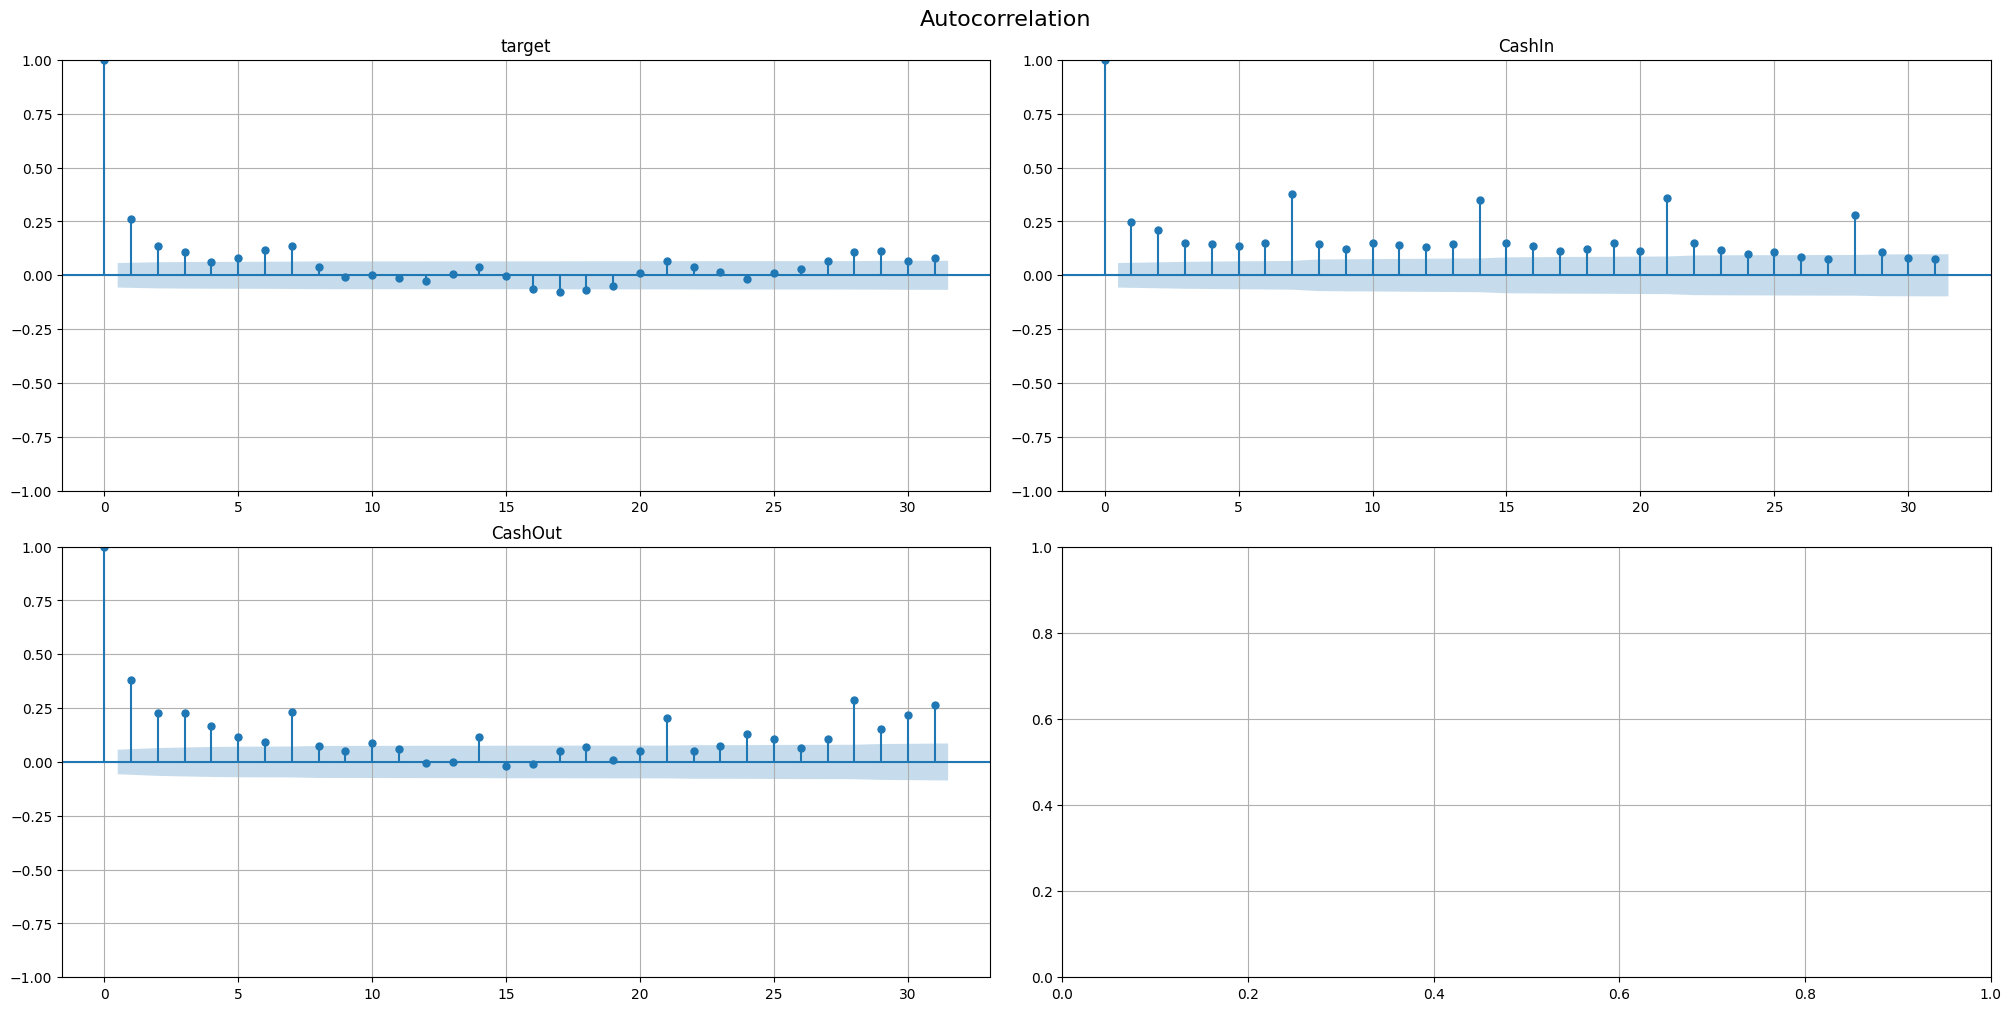

In [52]:
sample_acf_plot(ts, lags=31)

*Посмотрев на график, можно заметить, что каждая 7 точка выделяется сильной корреляцией, это хорошо, потому что 7 дней составляют неделю, а значит, зависимость закономерна и логична. Поэтому я возьму лаги, кратные 7*

In [53]:
lags = LagTransform(in_column="target", lags=[7,14,21,28,35,42,49,56,63,70,77], out_column="target_lag",)
seg = SegmentEncoderTransform()
stl = STLTransform(in_column="target", period=7, model="arima")

In [54]:
model_1 = CatBoostMultiSegmentModel()
transforms_1 = [
    lags,
    seg,
]
pipeline_1 = Pipeline(model=model_1, transforms=transforms_1, horizon=5)


model_2 = CatBoostModelPerSegment()
transforms_2 = [
    lags,
    stl,
]

pipeline_2 = Pipeline(model=model_2, transforms=transforms_2, horizon=5)

model_3 = AutoARIMAModel()
transforms_3 = [
    LagTransform(in_column="target", lags=[], out_column="target_lag",),
]

pipeline_3 = Pipeline(model=model_3, transforms=transforms_3, horizon=5)

pipeline_names = ["CatBoostMultiSegmentModel", "CatBoostModelPerSegment", "AutoARIMAModel"]
pipelines = [pipeline_1, pipeline_2, pipeline_3]
pipelines

[Pipeline(model = CatBoostMultiSegmentModel(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LagTransform(in_column = 'target', lags = [7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77], out_column = 'target_lag', ), SegmentEncoderTransform()], horizon = 5, ),
 Pipeline(model = CatBoostModelPerSegment(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LagTransform(in_column = 'target', lags = [7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77], out_column = 'target_lag', ), STLTransform(in_column = 'target', period = 7, model = 'arima', robust = False, model_kwargs = None, stl_kwargs = None, )], horizon = 5, ),
 Pipeline(model = AutoARIMAModel(), transforms = [LagTransform(in_column = 'target', lags = [], out_column = 'target_lag', )], horizon = 5, )]

In [55]:
metrics = []
forecasts = []
for pipeline in pipelines:
    pipl, forecast, _ = pipeline.backtest(
        ts=ts,
        metrics=[SMAPE(), MAE()],
        aggregate_metrics=True,
        n_jobs=5,
        n_folds=5,
    )
    pipl = pipl.iloc[:, 1:]
    forecasts.append(forecast)
    metrics.append(pd.DataFrame({"SMAPE":[pipl["SMAPE"].mean()], "MAE":[pipl["MAE"].mean()]}))
metrics = pd.concat(metrics)
metrics.index = pipeline_names
metrics

[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:   38.2s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   38.3s remaining:   57.5s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:   38.3s remaining:   25.6s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   38.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   38.4s finished
[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:  1.2min remaining:   47.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.


SMAPE           MAE
CatBoostMultiSegmentModel  79.023386  17667.733677
CatBoostModelPerSegment    77.555474  19641.744742
AutoARIMAModel             66.133757  13399.408083

In [56]:
voting_ensemble = VotingEnsemble(pipelines=pipelines, weights=[1, 1, 2], n_jobs=4)

pipl, voting_forecast, _ = voting_ensemble.backtest(
    ts=ts,
    metrics=[SMAPE(), MAE()],
    n_jobs=2,
    n_folds=5,
    aggregate_metrics=True,
)
pipl = pipl.iloc[:, 1:]
voting_ensamble_metrics = pd.DataFrame({"SMAPE":[pipl["SMAPE"].mean()], "MAE":[pipl["MAE"].mean()]})

voting_ensamble_metrics.index = ["voting ensemble"]
voting_ensamble_metrics

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:   42.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:   42.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  5.5min finished
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   3

SMAPE           MAE
voting ensemble  70.237498  14770.185045

In [57]:
#заменим горизонты пайплайнов, потому что DirectEnsemble ругается
pipeline_1 = Pipeline(model=model_1, transforms=transforms_1, horizon=5)

pipeline_2 = Pipeline(model=model_2, transforms=transforms_2, horizon=12)

pipeline_3 = Pipeline(model=model_3, transforms=transforms_3, horizon=19)

pipelines = [pipeline_1, pipeline_2, pipeline_3]
pipelines

[Pipeline(model = CatBoostMultiSegmentModel(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LagTransform(in_column = 'target', lags = [7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77], out_column = 'target_lag', ), SegmentEncoderTransform()], horizon = 5, ),
 Pipeline(model = CatBoostModelPerSegment(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LagTransform(in_column = 'target', lags = [7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77], out_column = 'target_lag', ), STLTransform(in_column = 'target', period = 7, model = 'arima', robust = False, model_kwargs = None, stl_kwargs = None, )], horizon = 12, ),
 Pipeline(model = AutoARIMAModel(), transforms = [LagTransform(in_column = 'target', lags = [], out_column = 'target_lag', )], horizon = 19, )]

In [58]:
direct_ensemble = DirectEnsemble(pipelines=pipelines, n_jobs=4)

pipl = direct_ensemble.backtest(
    ts=ts, metrics=[SMAPE(), MAE()], n_jobs=2, n_folds=5,
)[0].iloc[:, 1:]
direct_ensemble_metrics = pd.DataFrame({"SMAPE":[pipl["SMAPE"].mean()], "MAE":[pipl["MAE"].mean()]})

direct_ensemble_metrics.index = ["direct ensemble"]
direct_ensemble_metrics

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:   45.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:   46.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   3

SMAPE           MAE
direct ensemble  74.791394  17790.573348

In [59]:
metrics = pd.concat([metrics, voting_ensamble_metrics, direct_ensemble_metrics])
metrics

SMAPE           MAE
CatBoostMultiSegmentModel  79.023386  17667.733677
CatBoostModelPerSegment    77.555474  19641.744742
AutoARIMAModel             66.133757  13399.408083
voting ensemble            70.237498  14770.185045
direct ensemble            74.791394  17790.573348

*Что касается сравнительной таблицы, Арима показала себя лучше всех по показателям качества. На второе место можно поставить voting ensemble. Также важно отметить, что, в основном, ансамбли ведут себя лучше, чем модели по отдельности.*

### Задание 7. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная, смешанная dirrec). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [60]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

In [61]:
#YOUR CODE HERE#

In [62]:
#Рекурсивная стратегия
model = CatBoostMultiSegmentModel()
transforms = [
    lags,
    seg,
]

autoregressivepipeline = AutoRegressivePipeline(
    model=model, transforms=transforms, horizon=5, step=1
)

metrics_recursive_df, forecast_recursive_df, _ = autoregressivepipeline.backtest(
    ts=ts, metrics=[SMAPE(), MAE()]
)

metrics_recursive_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   31.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.5s finished


SMAPE             72.095677
MAE            14807.612036
fold_number        2.000000
dtype: float64

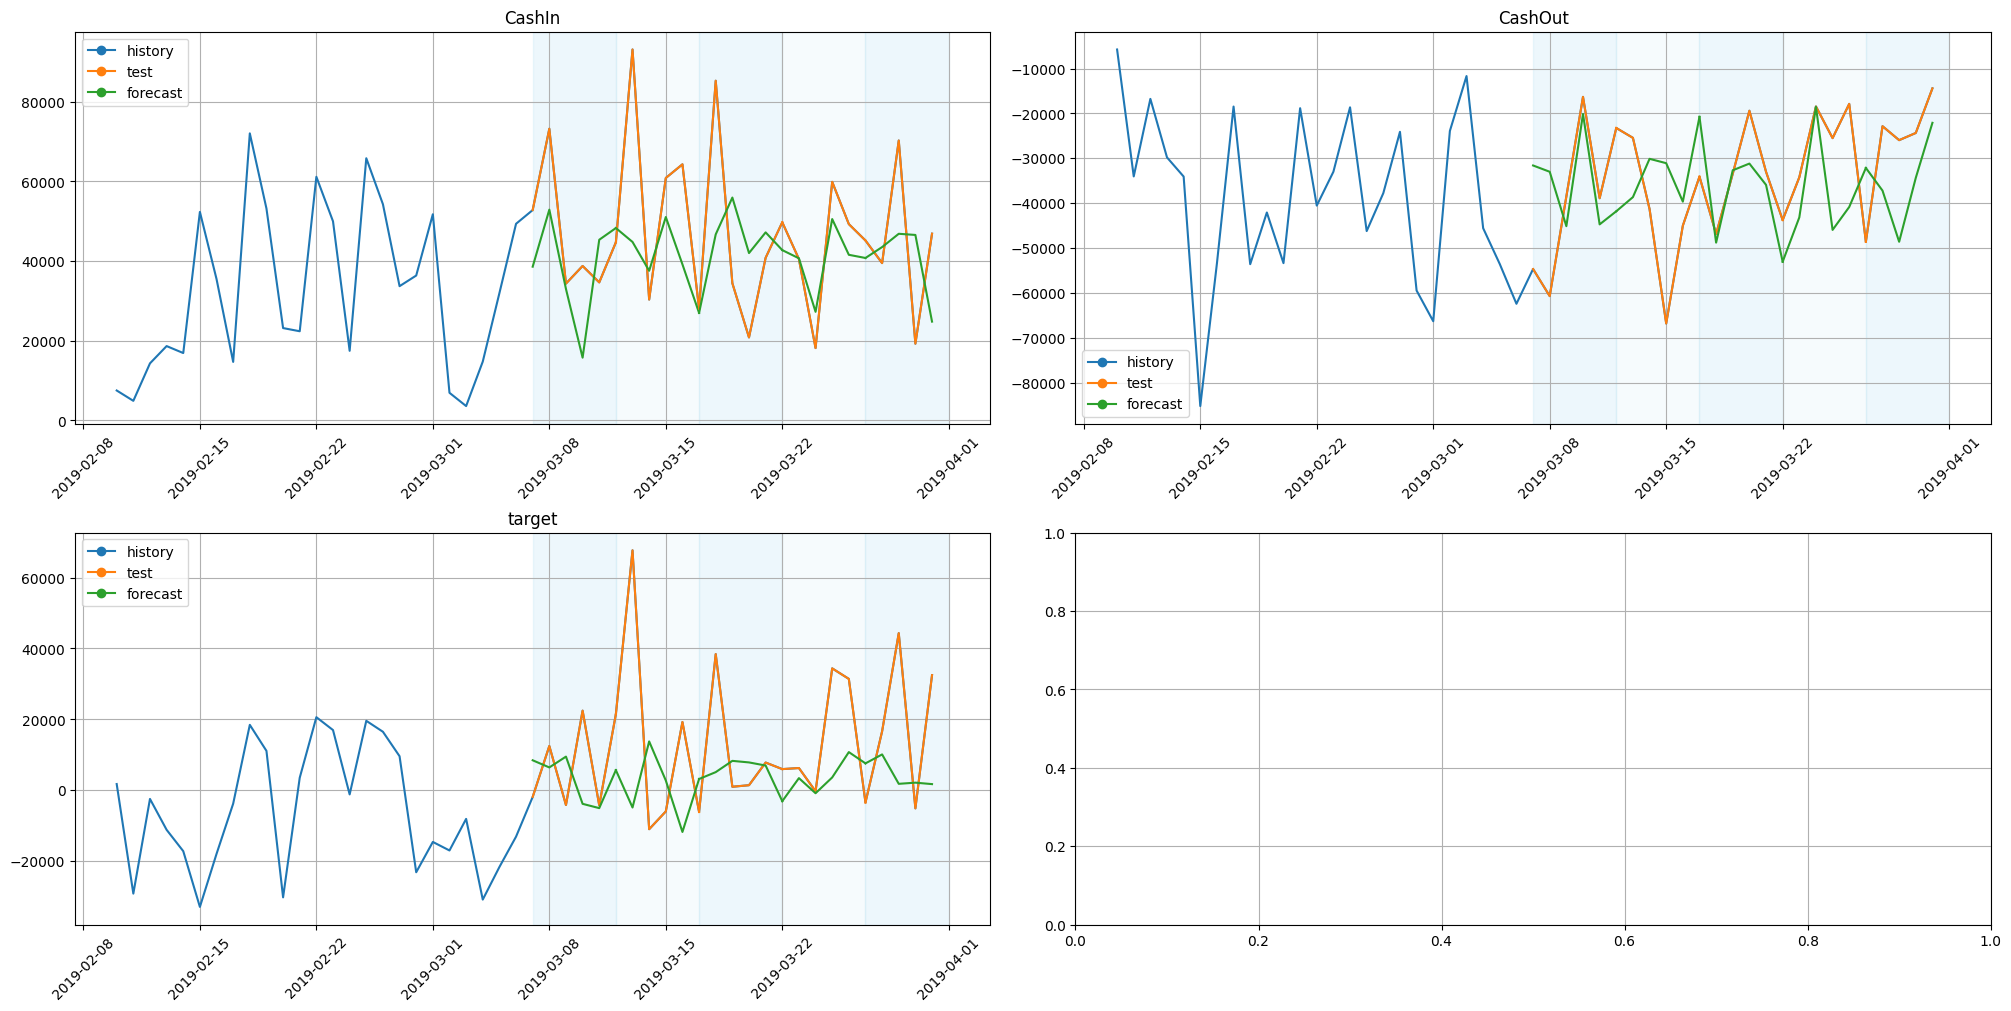

In [63]:
plot_backtest(forecast_recursive_df, ts, history_len=25)

In [64]:
model = CatBoostModelPerSegment()
transforms = [
    lags,
    stl,
]
autoregressivepipeline = AutoRegressivePipeline(
    model=model, transforms=transforms, horizon=5, step=1
)

metrics_recursive_df, forecast_recursive_df, _ = autoregressivepipeline.backtest(
    ts=ts, metrics=[SMAPE(), MAE()]
)

metrics_recursive_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   31.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   46.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   57.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished


SMAPE             76.777172
MAE            19195.913691
fold_number        2.000000
dtype: float64

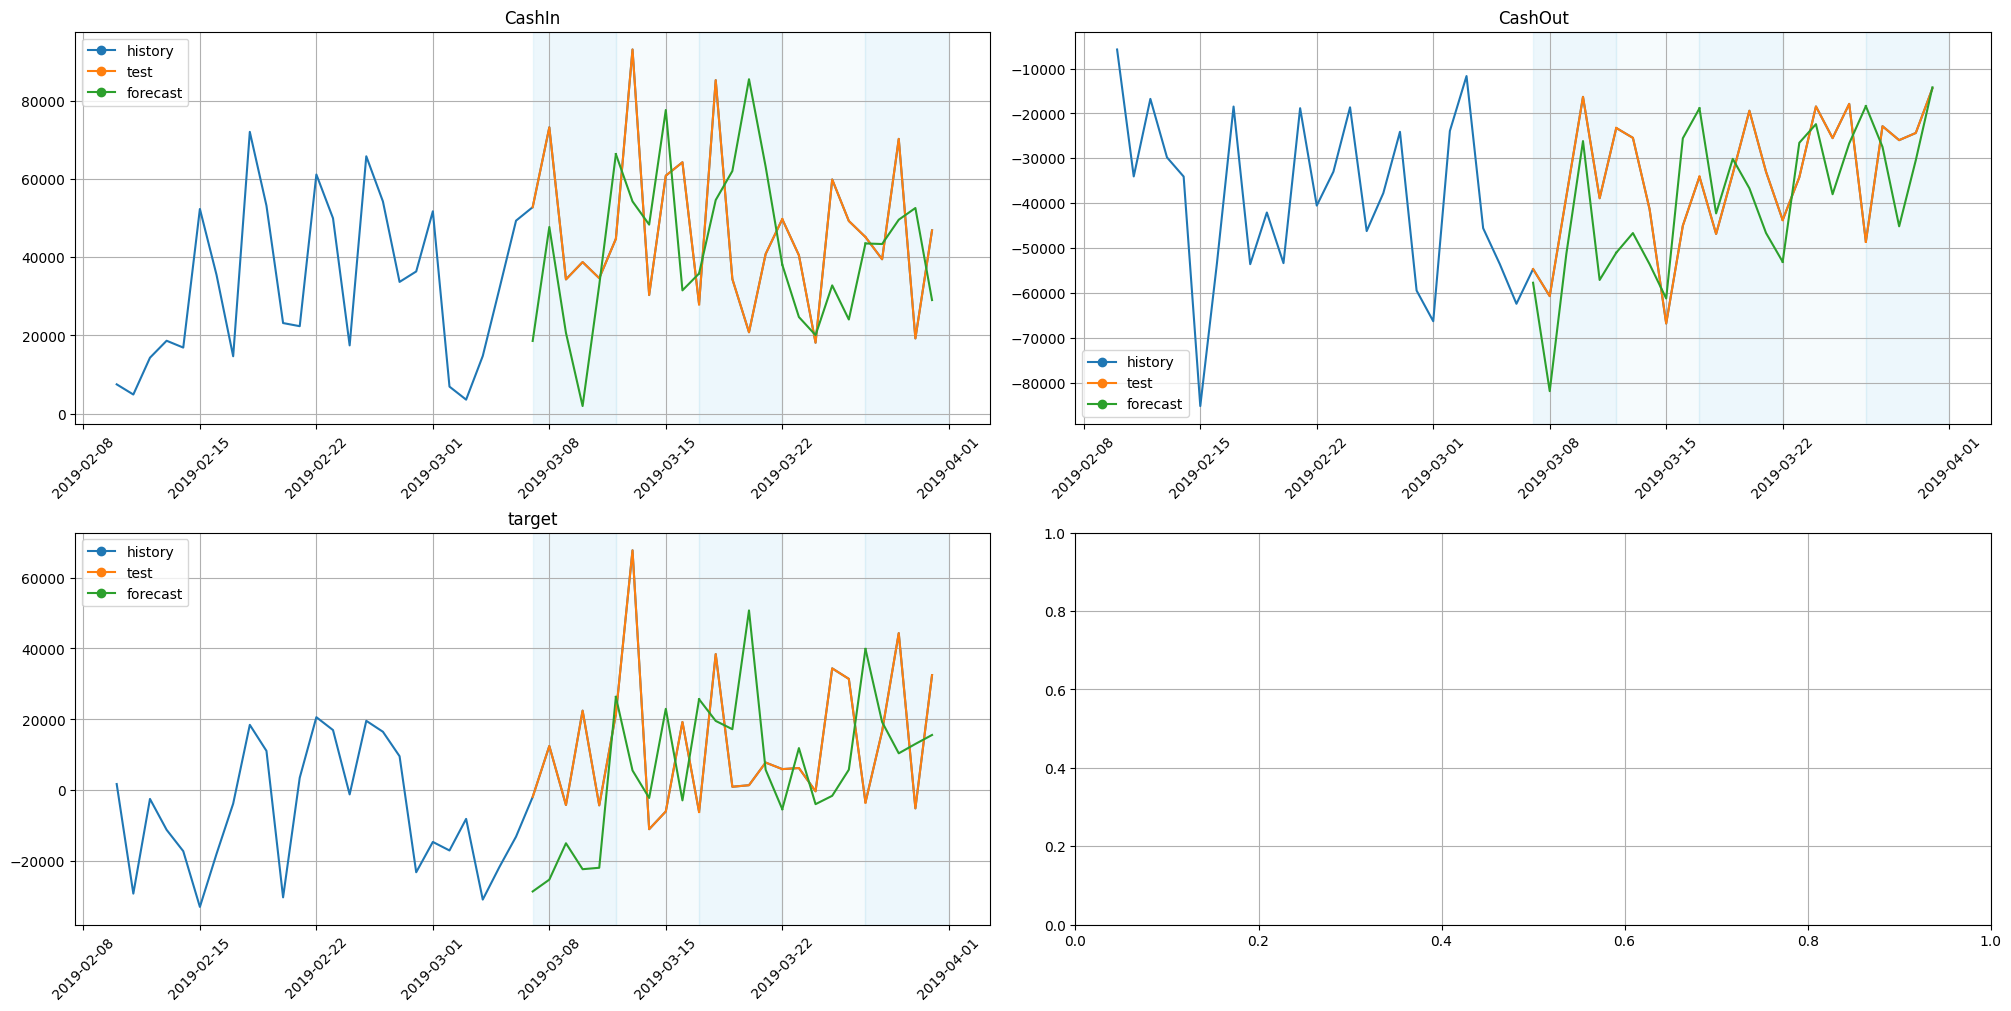

In [65]:
plot_backtest(forecast_recursive_df, ts, history_len=25)

In [66]:
model = AutoARIMAModel()
transforms = [
    LagTransform(in_column="target", lags=[], out_column="target_lag",),
]
autoregressivepipeline = AutoRegressivePipeline(
    model=model, transforms=transforms, horizon=5, step=1
)

metrics_recursive_df, forecast_recursive_df, _ = autoregressivepipeline.backtest(
    ts=ts, metrics=[SMAPE(), MAE()]
)

metrics_recursive_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin 

SMAPE             66.133757
MAE            13399.408083
fold_number        2.000000
dtype: float64

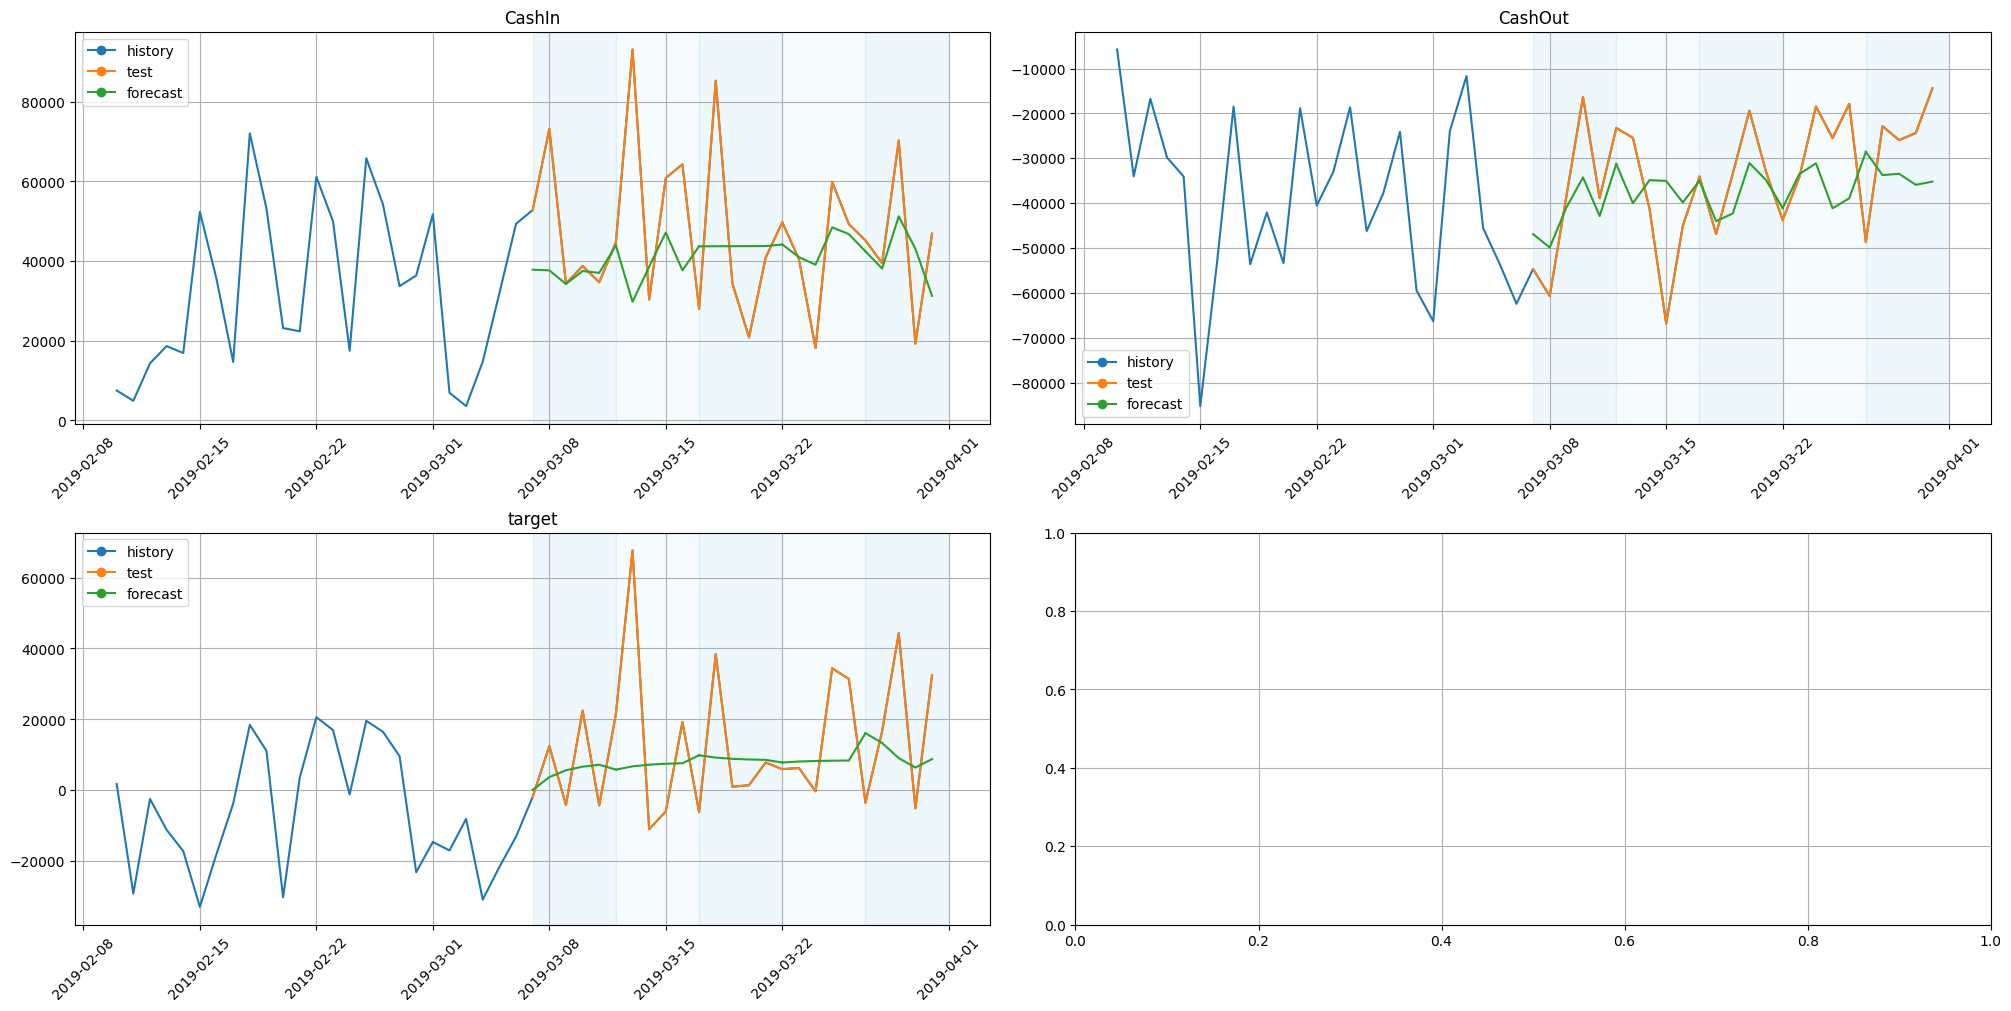

In [67]:
plot_backtest(forecast_recursive_df, ts, history_len=25)

In [68]:
#Прямая стратегия
#Прямую стратегию я уже смотрела в 6 задании, поэтому просто посмотрим графики

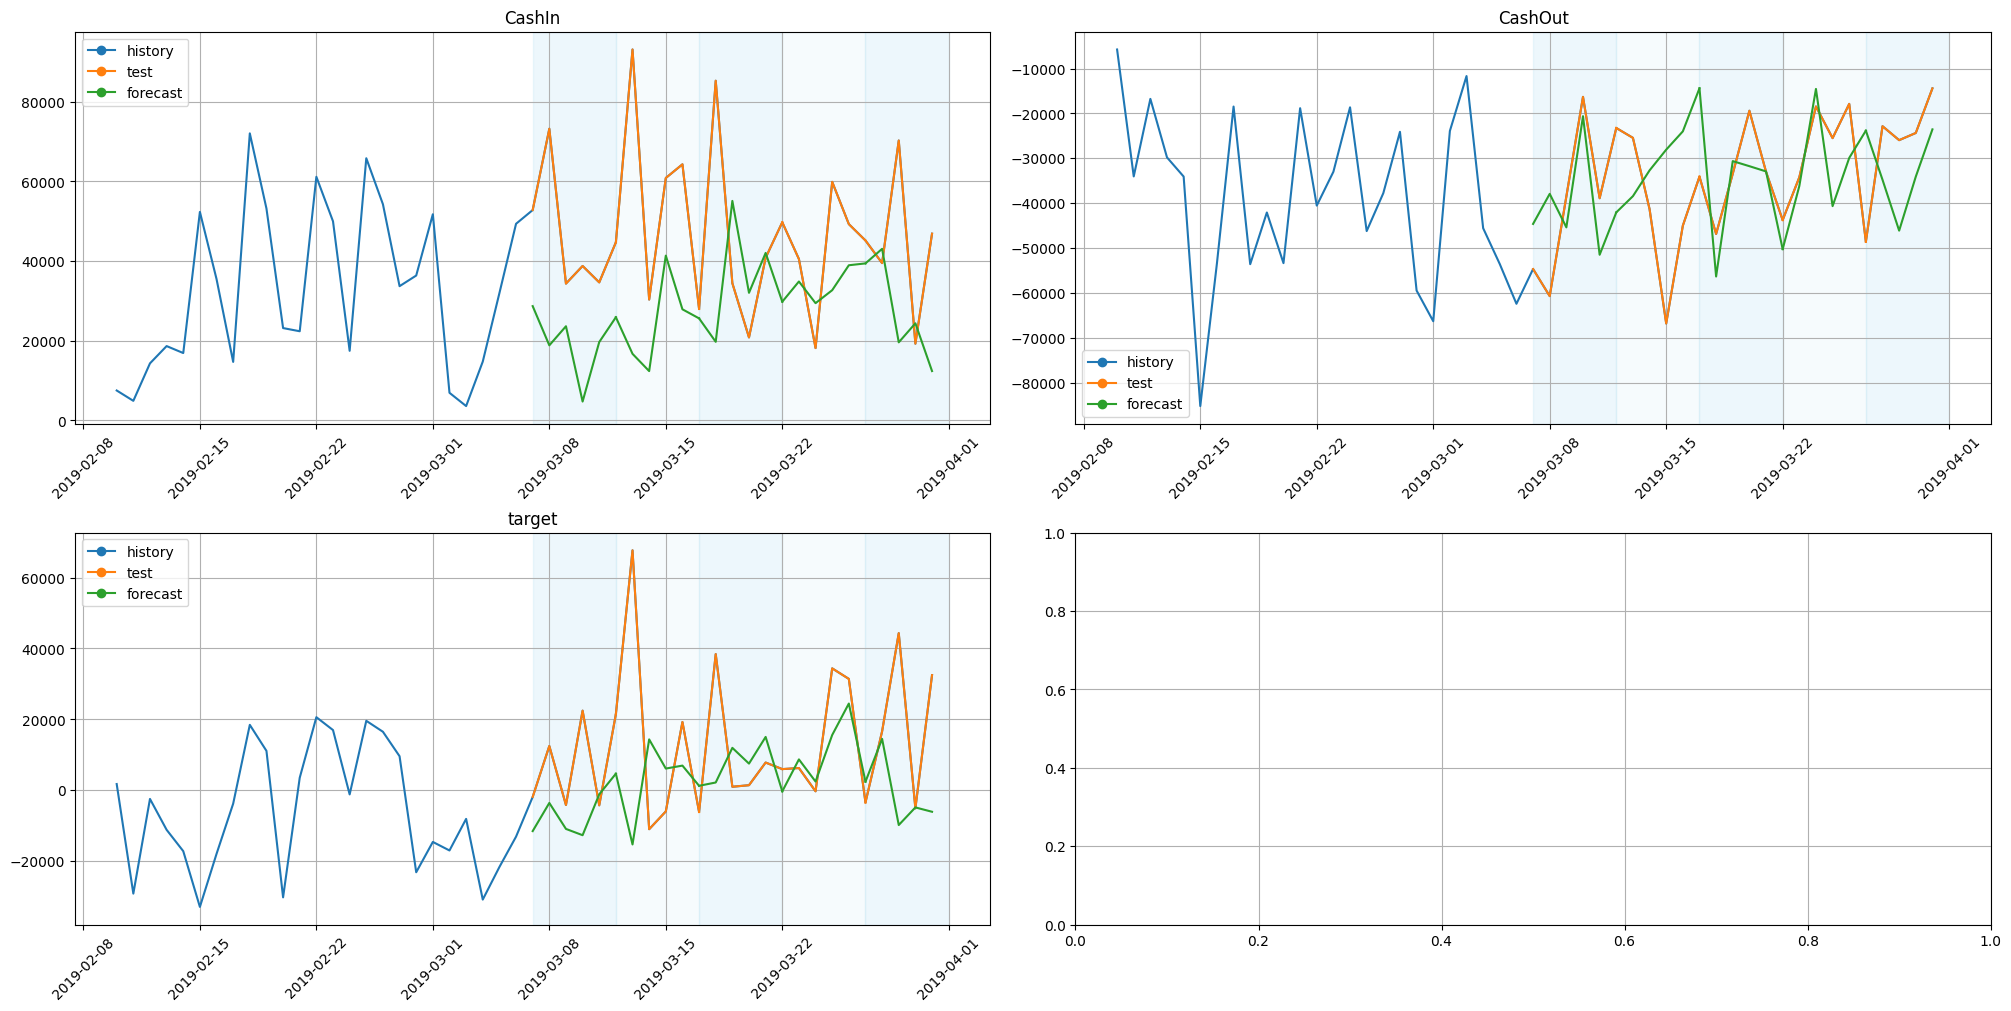

In [69]:
plot_backtest(forecasts[0], ts, history_len=25)

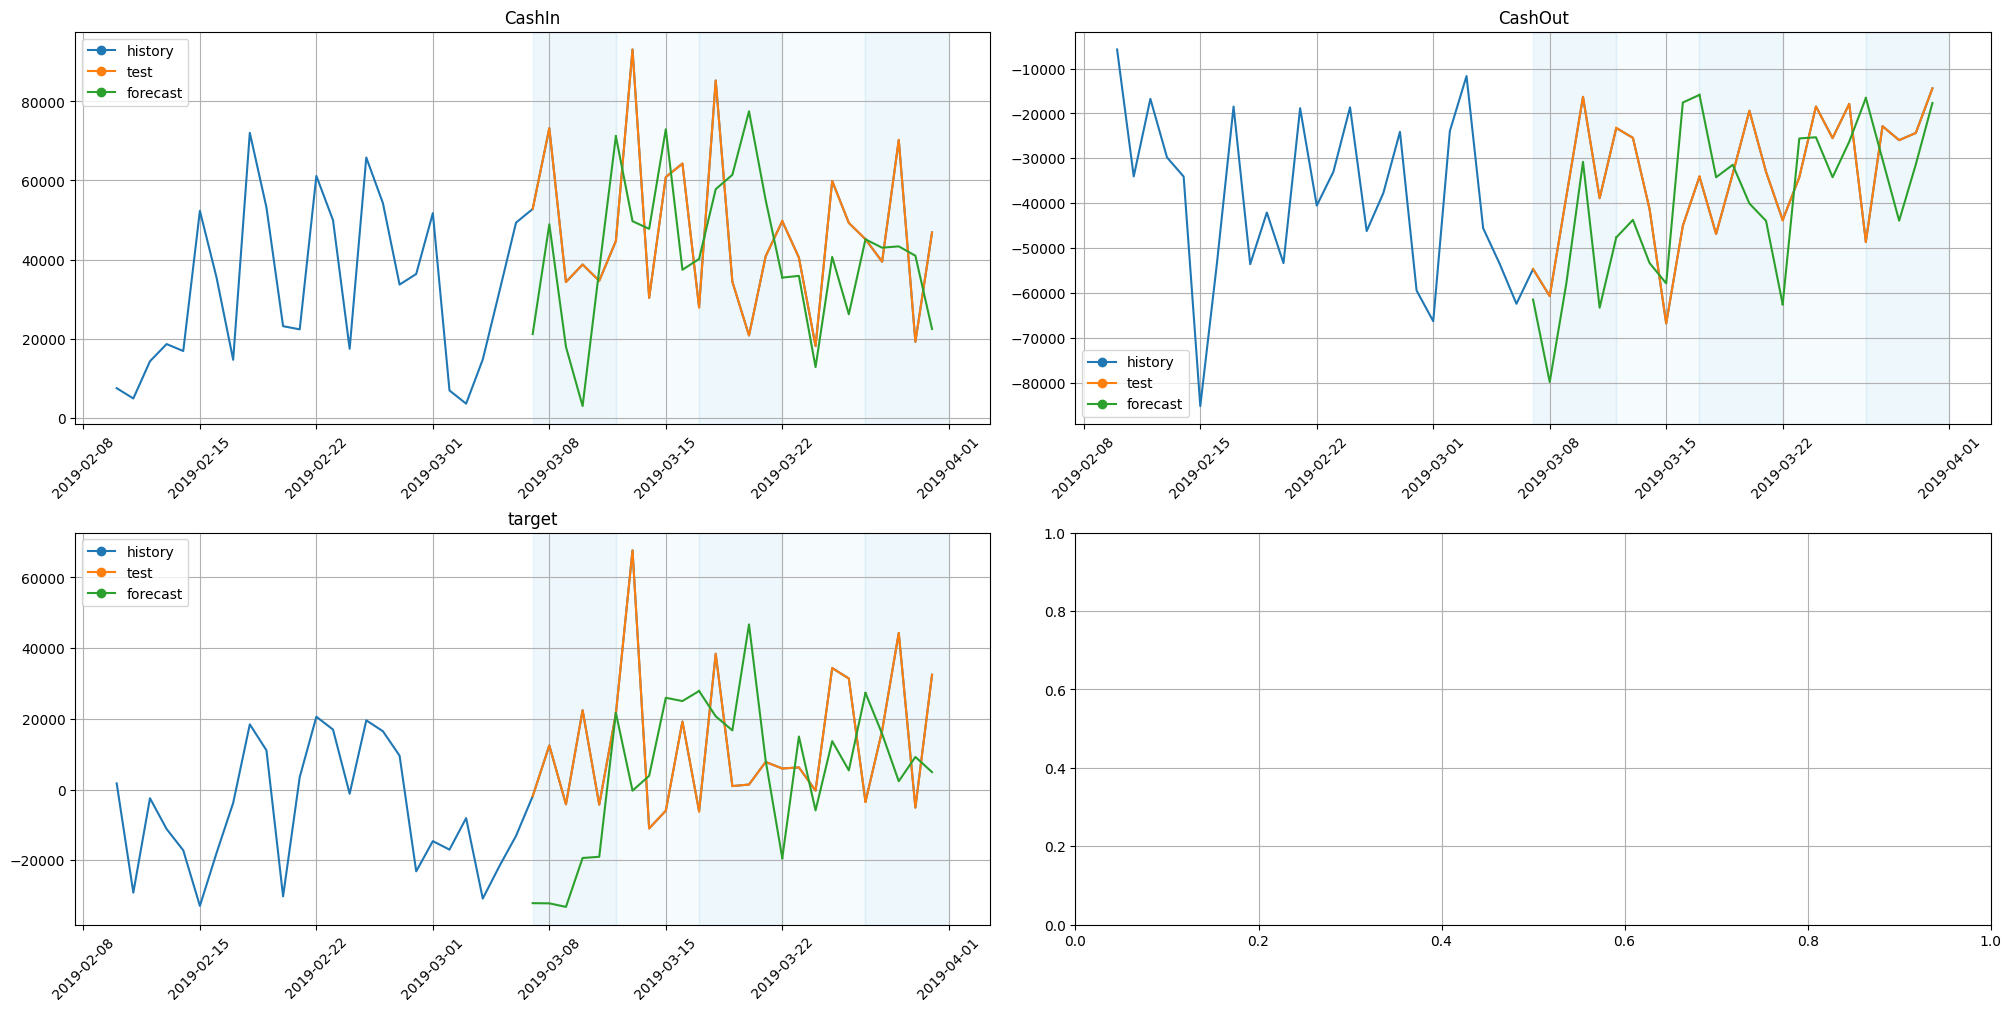

In [70]:
plot_backtest(forecasts[1], ts, history_len=25)

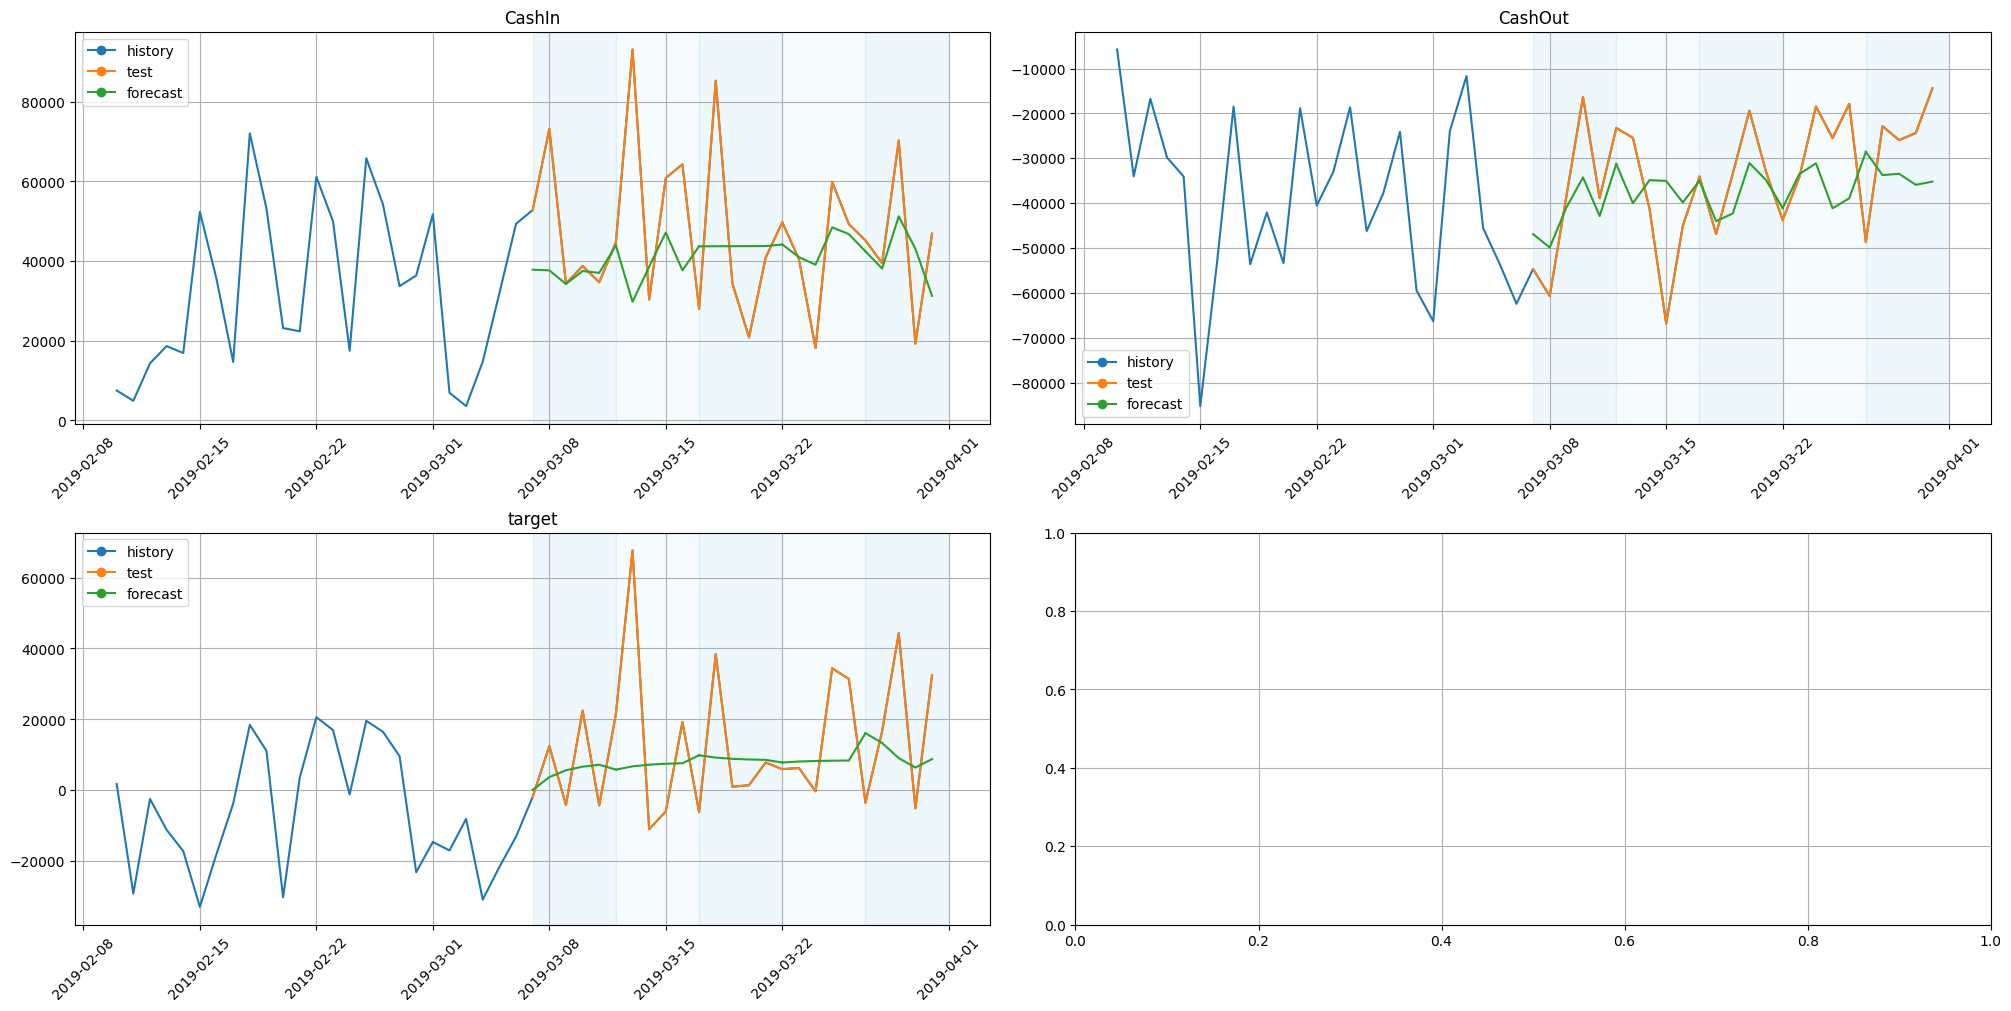

In [71]:
plot_backtest(forecasts[2], ts, history_len=25)

*Можно отметить, что рекурсивная стратегия заметно улучшает качество моделей по сравнению с прямой. Все три модели показывают себя по-разному. CatBoostMultiSegmentModel дает средние показатели качества и на графиках угадывает направления но недостаточно активно "скачет". CatBoostModelPerSegment же наоборот проявляет себя активно и по графикам нравится мне больше всех, хоть по качеству она занимает последнее место. AutoARIMAModel имеет лучшее качество, но на графиках очень неактивна*

### Задание 8. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [72]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

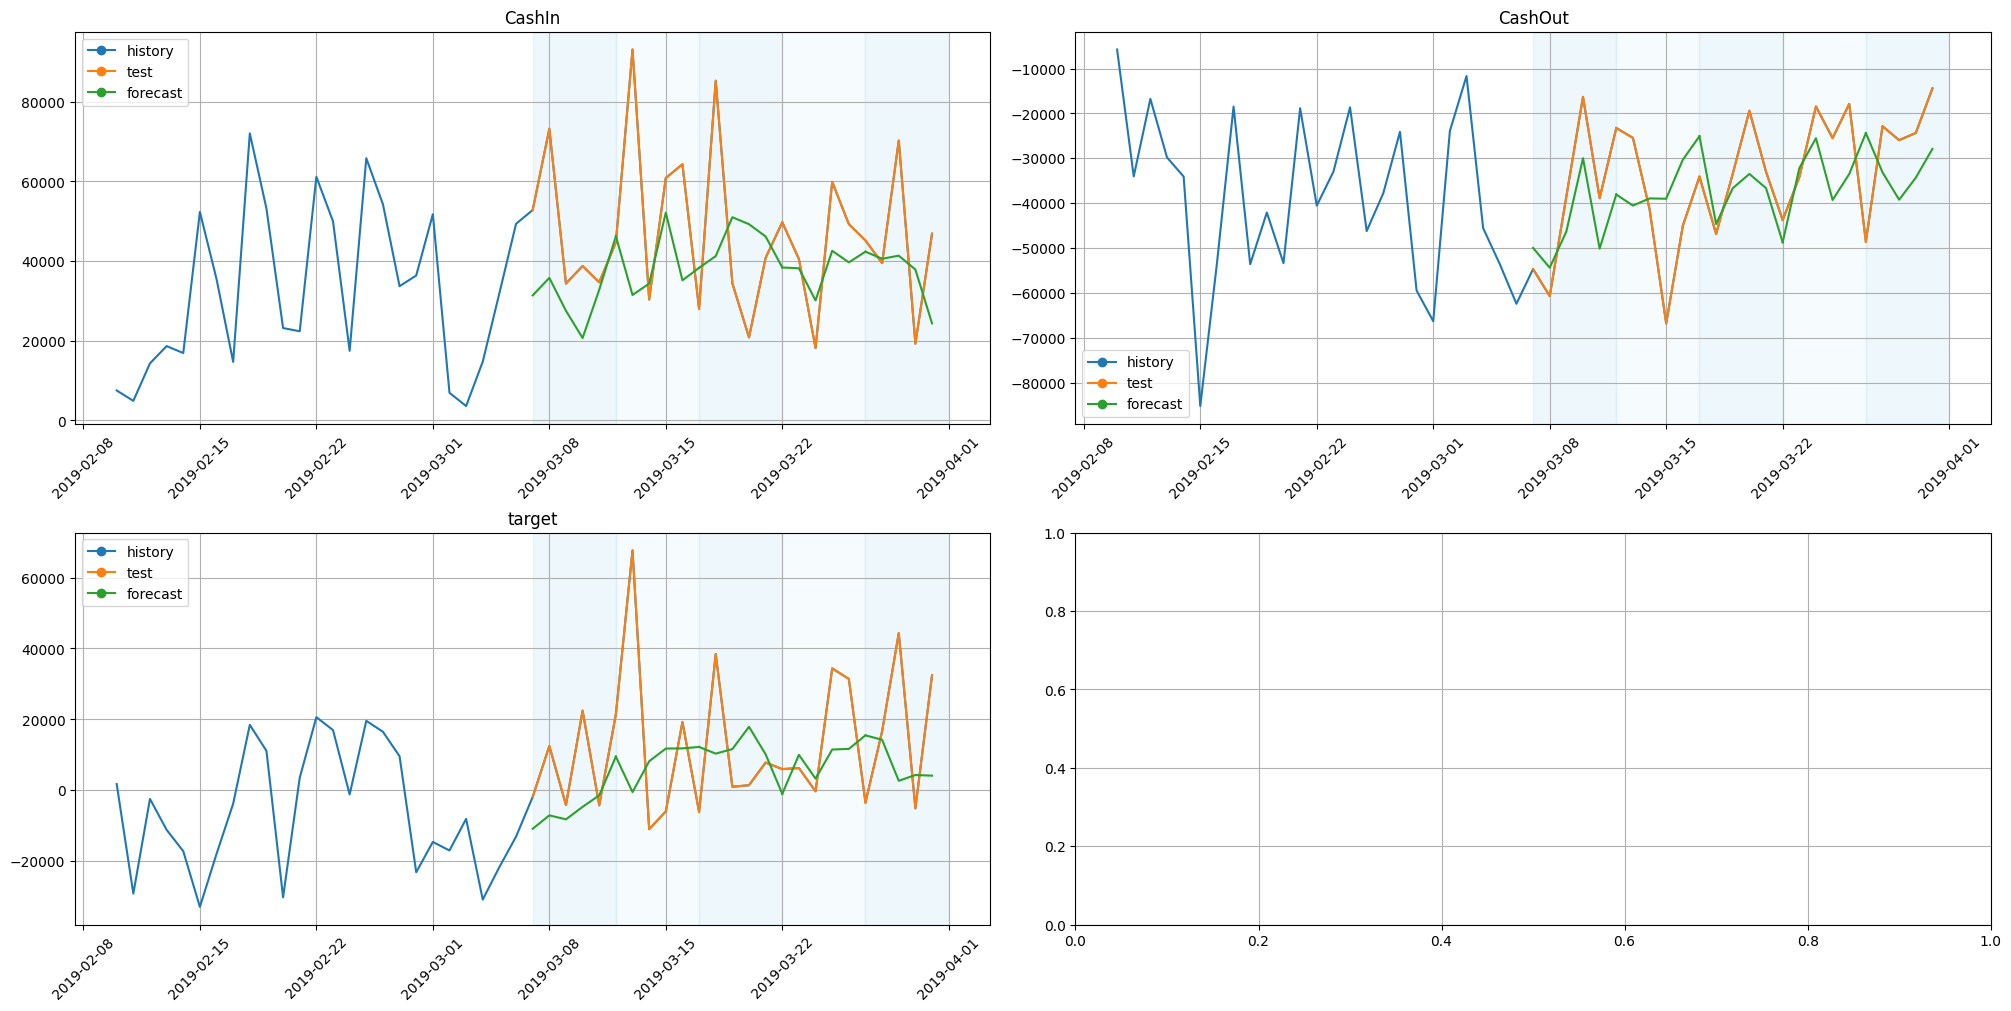

In [73]:
#YOUR CODE HERE#
plot_backtest(voting_forecast, ts, history_len=25)

*Я уже в 6 задании обучала voting ensemble, так что здесь просто отрисую графики. Что касается весов, их я выставляла, опираясь на показатели качества трех моделей, то есть Ариме поставила побольше, а остальным поровну.*

### Задание 9*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

In [74]:
#YOUR CODE HERE#